整理自： https://gymnasium.farama.org/tutorials/gymnasium_basics/vector_envs_tutorial/#sphx-glr-tutorials-gymnasium-basics-vector-envs-tutorial-py

如何使用矢量化环境来训练优势 Advantage Actor-Critic 代理。

**`矢量化环境`** 可以通过允许**相同环境**的**多个实例并行运行**（在多个 CPUs 上）来帮助实现**更快、更健壮的训练**。这可以显著**减少方差**，从而**加快训练速度**。

————————————————————

We will implement an Advantage Actor-Critic from scratch to look at how you can feed batched states into your networks to get a vector of actions (one action per environment) and calculate the losses for actor and critic on minibatches of transitions.
* 我们将从头开始实现一个 Advantage Actor-Critic，看看如何将**批状态**馈送到网络中，以获得**动作向量 (每个环境一个行动**)，并计算 actor 和 critic 在**小批量转换**上的损失。

Each minibatch contains the transitions of one sampling phase:
* 每个小批量包含一个采样阶段的过渡：

n_steps_per_update steps are executed in n_envs environments in parallel (multiply the two to get the number of transitions in a minibatch).

* N_steps_per_update 步在 n_envs 个环境中并行执行 (两者相乘等于 minibatch 中的转换数量)。


After each sampling phase, the losses are calculated and one gradient step is executed.

* 在每个采样阶段后，计算损失并执行一个梯度步。


To calculate the advantages, we are going to use the Generalized Advantage Estimation (GAE) method [2], which balances the tradeoff between variance and bias of the advantage estimates.

* 为了计算优势，我们将使用广义优势估计（GAE）方法，该方法平衡了优势估计的方差和偏差之间的权衡。

——————————————————

The A2C agent class is initialized with the number of features of the input state, the number of actions the agent can take, the learning rates and the number of environments that run in parallel to collect experiences.

* A2C 代理类是用**输入状态的特征数量**、**代理可以采取的动作数量**、**学习率**和**并行**运行以收集经验的**环境数量**来初始化的。

The actor and critic networks are defined and their respective optimizers are initialized.

* 定义了 actor 和 critic 网络，并初始化了各自的优化器。

The forward pass of the networks takes in a batched vector of states and returns a tensor of state values and a tensor of action logits.

* 网络的前向传递接受**状态的批向量**，并返回**状态价值张量**和**动作逻辑张量**。

The select_action method returns a tuple of the chosen actions, the log-probs of those actions, and the state values for each action.

* select_action 方法返回**所选动作的元组**、这些动作的 log-probs 以及每个动作的状态价值。

In addition, it also returns the entropy of the policy distribution, which is subtracted from the loss later (with a weighting factor ent_coef) to encourage exploration.

* 此外，它还返回策略分布的熵，该熵从稍后的损失中减去( 带有权重因子 ent_coef ) 以**鼓励探索**。

——————————————————

The get_losses function calculates the losses for the actor and critic networks (using GAE), which are then updated using the update_parameters function.

* get_losses 函数计算 actor 和 critic 网络的损失 (使用 GAE )，然后使用 update_parameters 函数更新这些损失。

In [1]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.2 MB/s eta 0:00:00


In [2]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch import optim

from tqdm import tqdm

import gymnasium as gym

The Actor-Critic combines elements of value-based and policy-based methods.

* Actor-Critic 整合了 基于价值 和 基于策略的方法 的要素。

In A2C, the agent has two separate neural networks: a critic network that estimates the state-value function, and an actor network that outputs logits for a categorical probability distribution over all actions.

* 在 A2C 中，代理有**两个独立的神经网络**：一个**评估状态价值函数**的 critic 网络，和一个**输出所有动作的分类概率分布**的 actor 网络。

The critic network is trained to minimize the mean squared error between the predicted state values and the actual returns received by the agent (this is equivalent to minimizing the squared advantages, because the advantage of an action is as the difference between the return and the state-value: $A(s,a) = Q(s,a) - V(s)$.

* **critic 网络**被训练成 最小化预测状态价值和代理收到的实际回报之间的均方误差 (这相当于**最小化 优势的平方**，因为一个动作的优势是回报和状态价值之间的差：$A(s， a) = Q(s， a) - V(s)$。

The actor network is trained to maximize the expected return by selecting actions that have high expected values according to the critic network.

* actor 网络经过训练，通过根据 critic 网络选择具有**高价值期望的动作**来最大化回报的期望。

重点在于<mark>如何使用**矢量化环境**和**领域随机化**来**加速 A2C 的训练过程**。</mark>

## A2C 类

In [3]:
class A2C(nn.Module):
  """
  (Synchronous) Advantage Actor-Critic 代理 类

  参数:
    n_features:  输入状态的特征数量
    n_actions: agent 可以选取的动作数量
    device:  本代码用 CPU 就可以
    actor_lr:
    critic_lr: 一般应比 actor_lr 略大
    n_envs:  并行用于收集数据的 环境数量
  """
  def __init__(
      self,
      n_features:int,
      n_actions:int,
      device: torch.device,
      critic_lr:float,
      actor_lr:float,
      n_envs: int,
      )->  None:
    super().__init__()
    self.device = device
    self.n_envs = n_envs

    # actor 网络初始化
    actor_layers = [
        nn.Linear(n_features, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, n_actions),
    ]
    self.actor = nn.Sequential(*actor_layers).to(self.device)
    self.actor_optim = optim.Adam(self.actor.parameters(),lr=actor_lr)

    # critic 网络初始化
    critic_layers = [
        nn.Linear(n_features, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
    ]
    self.critic = nn.Sequential(*critic_layers).to(self.device)
    self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)

  def forward(self, x:np.ndarray)-> tuple[torch.Tensor, torch.Tensor]:
    """
    网络的正向传递

    参数：
      x: 小批状态

    返回：
      状态价值: [n_envs,]
      action_logits_vec: [n_envs, n_actions]
    """
    x = torch.Tensor(x).to(self.device)
    state_values = self.critic(x) # [n_envs,]
    action_logits_vec = self.actor(x)  # [n_envs, n_actions]
    return (state_values, action_logits_vec)

  def select_action(self, x: np.ndarray)-> tuple[torch.Tensor, torch.Tensor, torch.Tensor,torch.Tensor]:
    """
    返回 选定的动作的元组 和 这些动作的 log-probs

    参数:
      x: 小批状态
    返回:
      actions: [n_steps_per_update, n_envs]
      action_log_probs: [n_steps_per_update, n_envs]
      state_values:  [n_steps_per_update, n_envs]
    """
    state_values, action_logits = self.forward(x)
    action_pd = torch.distributions.Categorical(logits=action_logits)
    actions = action_pd.sample()
    action_log_probs = action_pd.log_prob(actions)
    entropy = action_pd.entropy()
    return (actions, action_log_probs, state_values, entropy)

  def get_losses(
      self,
      rewards: torch.Tensor,
      action_log_probs: torch.Tensor,
      value_preds: torch.Tensor,
      entropy: torch.Tensor,
      masks: torch.Tensor,
      gamma: float,
      lam: float,
      ent_coef: float,
      device: torch.device,
  ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    计算 actor 和 critic 在小批量转换 的损失
        使用 Generalized Advantage Estimation (GAE) 计算优势

    参数：
      rewards:
      action_log_probs:
      value_preds:
      masks: 回合里的 n-step 数据 A tensor with the masks for each time step in the episode, with shape [n_steps_per_update, n_envs].
      gamma:
      lam: lam=1对应于蒙特卡罗抽样，方差大，无偏差；
          lam=0 对应的是低方差但有偏的正常 TD-Learning
      device:
    返回:
      critic_loss:
      actor_loss:
    """
    T = len(rewards)
    advantages = torch.zeros(T, self.n_envs, device=device)

    # 用 GAE 计算 优势  mask[t]: 第 t 个时间步为 终止状态， 则 mask[t] = 0, 若为 运行状态 则 masks[t] = 0
    gae = 0.0
    for t in reversed(range(T-1)):
      td_error = (rewards[t] + gamma * masks[t] * value_preds[t+1] - value_preds[t])
      gae = td_error + gamma * lam * masks[t] * gae
      advantages[t] = gae

    # 计算 actor  和 critic 在小批次上的 损失
    critic_loss =advantages.pow(2).mean()
    actor_loss = (-(advantages.detach() * action_log_probs).mean() - ent_coef * entropy.mean() )

    return (critic_loss, actor_loss)

  def update_parameters(self, critic_loss:torch.Tensor, actor_loss: torch_Tensor) -> None:
    """
    更新 actor 和 critic 网络的参数
    """
    self.critic_optim.zero_grad()
    critic_loss.backward()
    self.critic_optim.step()

    self.actor_optim.zero_grad()
    actor_loss.backward()
    self.actor_optim.step()

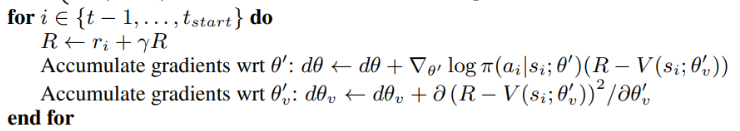

## 矢量化环境 定义

当你计算两个神经网络在一个 **`epoch`** 上的损失时，它可能有**很高的方差**。在矢量化的环境中，我们可以并行地处理 n_envs 个环境，从而获得线性加速（这意味着理论上，我们收集样本的速度要快 n_envs 倍），我们可以用它来计算当前策略和 critic 网络的损失。当我们**使用更多的样本来计算损失**时，它将具有**更低的方差**，因此**可以更快地学习**。

A2C 是一种同步方法，这意味着网络的参数更新是确定的 (在每个采样阶段之后)。我们仍然可以**使用异步矢量 envs 来生成多个进程**，以便在**并行**环境中执行。

创建矢量环境最简单的方法是调用 **`gym.vector.make`**，它**创建同一环境的多个实例**：

https://gymnasium.farama.org/environments/box2d/

In [4]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376103 sha256=3fa4d74e86d1364413647218dad3a878f0764db20b77b8ab54258d4b67e8f097
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


#### 同步环境

In [5]:
# !pip install box2d-kengz

In [6]:
# !pip install box2d

In [7]:
envs = gym.make_vec("LunarLander-v3", num_envs = 3, max_episode_steps = 600)
envs  # 同步环境

SyncVectorEnv(LunarLander-v3, num_envs=3)

In [8]:
envs = gym.make_vec("LunarLander-v3", num_envs=3, vectorization_mode="sync")
envs

SyncVectorEnv(LunarLander-v3, num_envs=3)

## 域随机化

如果我们想要**随机化训练环境**以获得**更健壮的代理** (可以处理环境的不同参数化，因此可能具有更高的泛化程度)，我们可以手动设置所需的参数或**使用伪随机数生成器来生成它们**。


### 手动设置参数

手动设置 3 个具有不同参数的并行 "LunarLander-v3" envs：

#### 异步

In [9]:
## 异步 !!!

envs = gym.vector.AsyncVectorEnv([
    lambda: gym.make(
        "LunarLander-v3",
        gravity=-10.0,
        enable_wind=True,
        wind_power=15.0,
        turbulence_power=1.5,
        max_episode_steps=600,
    ),
    lambda: gym.make(
        "LunarLander-v3",
        gravity=-9.8,
        enable_wind=True,
        wind_power=10.0,
        turbulence_power=1.3,
        max_episode_steps=600,
    ),
    lambda: gym.make(
        "LunarLander-v3",
        gravity=-7.0,
        enable_wind=False,
        max_episode_steps=600,
    ),

])

envs

AsyncVectorEnv(num_envs=3)

### 随机生成参数


**随机生成** 3 个并行的 "LunarLander-v3" 环境的参数，使用 np.clip 以保持在推荐的参数空间中：

分布为： 环境的标准参数为均值和标准方差 (值的范围) 的正态分布

In [10]:
envs = gym.vector.AsyncVectorEnv([
    lambda: gym.make(
        "LunarLander-v3",
        gravity = np.clip(np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max=-0.01),
        enable_wind=np.random.choice([True, False]),
        wind_power=np.clip(np.random.normal(loc=15.0,scale=1.0), a_min=0.01, a_max=19.99),
        turbulence_power=np.clip(np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99),
        max_episode_steps=600,
    )
    for i in range(3)
])
envs

AsyncVectorEnv(num_envs=3)

## 训练

In [13]:
# 参数设置

# 环境参数
n_envs = 10  # 实验验证过的， 10 个并行环境是用时最少的
n_updates = 1000
n_steps_per_update = 128
randomize_domain = True   # !!!

# agent 参数
gamma = 0.999
lam = 0.95 # GAE 的参数
ent_coef = 0.01
actor_lr = 0.001
critic_lr = 0.005
# actor 有低一些的学习率， 则价值目标更平稳，从而更好地估计 critic

# 环境配置
if randomize_domain: #
  envs = gym.vector.AsyncVectorEnv([
    lambda: gym.make(
        "LunarLander-v3",
        gravity = np.clip(np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max=-0.01),
        enable_wind=np.random.choice([True, False]),
        wind_power=np.clip(np.random.normal(loc=15.0,scale=1.0), a_min=0.01, a_max=19.99),
        turbulence_power=np.clip(np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99),
        max_episode_steps=600,
    )
    for i in range(n_envs)
  ])
else:  #
  envs = gym.make_vec("LunarLander-v3", num_envs=n_envs, max_episode_steps=600)

obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

# 设置 device
use_cuda = False
if use_cuda:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

## 初始化 agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)


使用 RecordEpisodeStatistics 包装器来记录回合长度和回报，并且我们还保存损失和熵，以便在代理完成训练后绘制它们。

回合结束环境会自动重置，固定步数。

https://gymnasium.farama.org/api/vector/wrappers/#gymnasium.wrappers.vector.RecordEpisodeStatistics

In [14]:
# 创建一个 wrapper 环境， 存储 回合回报 和 回合长度
envs_wrapper = gym.wrappers.vector.RecordEpisodeStatistics(envs, buffer_length=n_envs * n_updates)

critic_losses = []
actor_losses = []
entropies = []

# 用 tqdm 来获取 训练的进度条
for sample_phase in tqdm(range(n_updates)):
  ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
  ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
  ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
  masks = torch.zeros(n_steps_per_update, n_envs, device=device)

  # 在训练开始时重置所有环境，获取初始状态
  if sample_phase == 0:
    states, info = envs_wrapper.reset(seed=42)

  # 在并行环境中 玩 n 步 来收集数据
  for step in range(n_steps_per_update):
    actions, action_log_probs, state_value_preds, entropy = agent.select_action(states)
    # 执行动作获取 下一个状态 和 奖励
    states, rewards, terminated, truncated, infos = envs_wrapper.step(actions.cpu().numpy())
    # 储存互动的数据
    ep_value_preds[step] = torch.squeeze(state_value_preds)
    ep_rewards[step] = torch.tensor(rewards, device=device)
    ep_action_log_probs[step] = action_log_probs

    # 添加一个 mask , 用于后续的计算
    # 如果回合正在进行， mask = 1, 回合若是终止， mask = 0； 类似于 dones
    # 这里 不截断 为回合
    masks[step] = torch.tensor([not term for term in terminated])

  # 收集一定量的数据后， 计算损失
  critic_loss, actor_loss = agent.get_losses(
      ep_rewards,
      ep_action_log_probs,
      ep_value_preds,
      entropy,
      masks,
      gamma,
      lam,
      ent_coef,
      device,
  )

  # 更新 actor 和 critic 网络
  agent.update_parameters(critic_loss, actor_loss)

  # 损失的log  和 熵
  critic_losses.append(critic_loss.detach().cpu().numpy())
  actor_losses.append(actor_loss.detach().cpu().numpy())
  entropies.append(entropy.detach().mean().cpu().numpy())


100%|██████████| 1000/1000 [15:34<00:00,  1.07it/s]


## 可视化

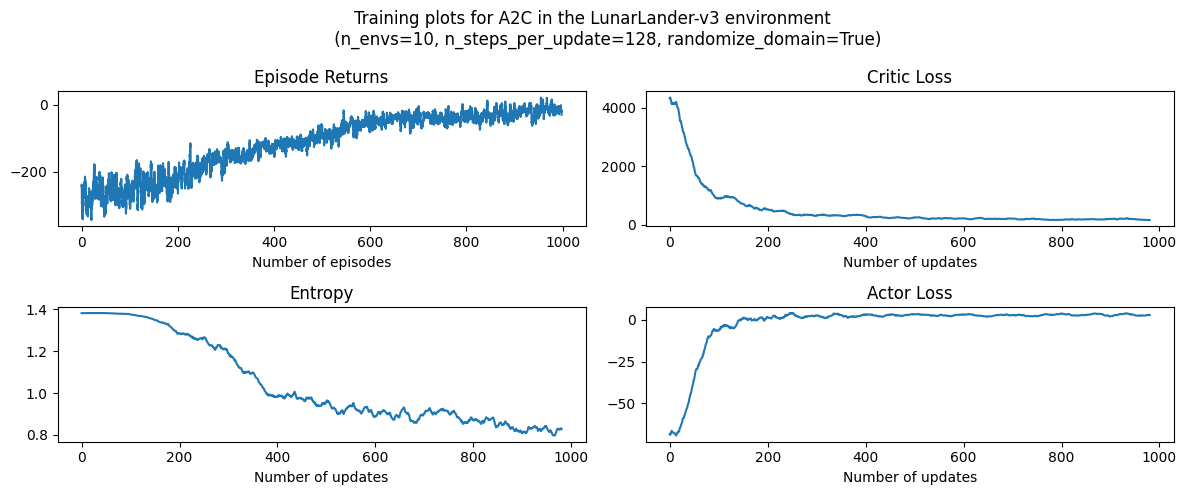

In [15]:
rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the LunarLander-v3 environment \n \
    (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={randomize_domain})"
)

# 回合的回报
axs[0][0].set_title("Episode Returns")
### 平滑后的数据
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )/ rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average))/ n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# 熵
axs[1][0].set_title("Entropy")
### 平滑后的数据
entropy_moving_average = (
    np.convolve(
        np.array(entropies),
        np.ones(rolling_length),
        mode="valid",
    )/ rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")

# critic loss
axs[0][1].set_title("Critic Loss")
### 平滑后的数据
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )/ rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")

# actor loss
axs[1][1].set_title("Actor Loss")
### 平滑后的数据
actor_losses_moving_average = (
    np.convolve(
        np.array(actor_losses).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )/ rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()


与同步环境相比，**异步**环境可以带来**更快的训练时间和更高的数据收集加速**。这是因为异步环境允许多个代理并行地与它们的环境交互，而同步环境允许**串行地运行多个环境**。这将为异步环境带来更高的效率和更快的训练时间。


与同步环境相比，**异步环境**的训练时间要**快得多**




然而，重要的是要注意，增加并行向量环境的数量可能会导致**在一定数量的环境后训练时间变慢**（见下图，其中智能体被训练直到平均训练回报高于 -120）。训练时间较慢可能是因为在相对较少的环境数量之后，**环境的梯度已经足够好了**（特别是如果环境不是很复杂的话）。在这种情况下，增加环境的数量并**不会提高学习速度，实际上会增加运行时间，这可能是由于计算梯度所需的额外时间。**对于 LunarLander-v3，最佳性能配置使用具有**10 个并行环境的 AsyncVectorEnv**，但具有更高复杂性的环境可能需要更多并行环境来实现最佳性能。

## 存储/加载 权重

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd /content/drive/MyDrive/Actor-Critics_Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 Actor-Critics_Test

/content/drive/MyDrive/Actor-Critics_Test
A2C.csv  Actor-Critics.csv  Actor-Critics_QAC.csv  weights


In [18]:
# 存储 网络权重
actor_weights_path = "/content/drive/MyDrive/Actor-Critics_Test/weights/actor_weights_v2.h5"
critic_weights_path = "/content/drive/MyDrive/Actor-Critics_Test/weights/critic_weights_v2.h5"

if not os.path.exists("weights"):
  os.mkdir("weights")

torch.save(agent.actor.state_dict(), actor_weights_path)
torch.save(agent.critic.state_dict(), critic_weights_path)

In [19]:
## 加载 网络权重

agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs=1)

agent.actor.load_state_dict(torch.load(actor_weights_path))
agent.critic.load_state_dict(torch.load(critic_weights_path))
agent.actor.eval()
agent.critic.eval()

<ipython-input-19-d432d605a136>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.actor.load_state_dict(torch.load(actor_weights_path))
<ipython-input-19-d432d605a136>:

Sequential(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

## 策略可视化

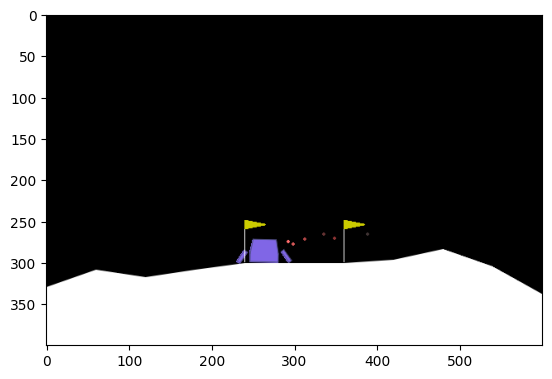

In [27]:
from IPython import display
%matplotlib inline

n_showcase_episodes = 2 # 演示 2 个回合

for episode in range(n_showcase_episodes):
  print(f"starting episode {episode}...")

  if randomize_domain: #
    env = gym.vector.AsyncVectorEnv([
        lambda: gym.make(
            "LunarLander-v3",
            render_mode="rgb_array",
            gravity = np.clip(np.random.normal(loc=-10.0, scale=1.0), a_min=-11.99, a_max=-0.01),
            enable_wind=np.random.choice([True, False]),
            wind_power=np.clip(np.random.normal(loc=15.0,scale=1.0), a_min=0.01, a_max=19.99),
            turbulence_power=np.clip(np.random.normal(loc=1.5, scale=0.5), a_min=0.01, a_max=1.99),
            max_episode_steps=600,
        )
        for i in range(1)
    ])
  else:  # 同步 ！！A2C
    env = gym.make_vec("LunarLander-v3", render_mode="rgb_array", max_episode_steps=600)

  # 获取初始状态
  state, info = env.reset()

  img = plt.imshow(env.render()[0]) # only call this once

  done = False
  while not done:
    # 可视化
    img.set_data(env.render()[0])
    display.display(plt.gcf())
    display.clear_output(wait=True)
    with torch.no_grad():
      actions, _, _, _ = agent.select_action(state[None,:])
    state, reward, terminated, truncated, info = env.step([actions.item()])
    done = terminated or truncated

env.close()


## 回报分析

In [28]:
import pandas as pd

my_df = pd.read_csv('/content/drive/MyDrive/Actor-Critics_Test/A2C.csv', index_col=0)   # index_col=0 指定行索引的位置
my_df.to_csv('/content/drive/MyDrive/Actor-Critics_Test/A2C_1.csv')
my_df

,randomize_domain=False
0,-158.242634
1,-169.507533
2,-183.674368
3,-184.298293
4,-183.368921
...,...
4861,37.268605
4862,36.688973
4863,45.210451
4864,36.061573


In [29]:
my_df["randomize_domain=True"] = episode_returns_moving_average

my_df.to_csv("/content/drive/MyDrive/Actor-Critics_Test/A2C.csv")
my_df

ValueError: Length of values (9981) does not match length of index (4866)

域随机化后，运行的回合数更多

In [ ]:
import seaborn as sns
# 绘图比较

sns.lineplot(data=my_df, linewidth=1, palette={'randomize_domain=False':'blue','randomize_domain=True':'red'},style_order=['randomize_domain=True','randomize_domain=False']).set(
    title="Comparison of returns on {}".format("LunarLander-v3")
)